# Introduction

The objective of this assignment is to scrape consumer reviews from a set of web pages and evaluate the performance of text classification on the data.

Each review has a star rating. For this assignment, we will assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews as “positive”.

The two review categories we chose are: Bars and Restaurants

- There are 68 different bars, with a total of 1,460 reviews.
- There are 67 different restaurants, with a total of 1440 reviews.

We chose these two categories because we assumed that the reviews for these two would be most similar. We hoped that a model we trained on one category would have a reasonable performance on the second category.

## Authors

- Shane Ó Gruagáin - 15383996
- James Carron - 15333196

## Process

The assignment was split into 3 tasks

Task 1: Data Collection and Preparation

- Scrape all reviews for each category and store them as two separate datasets. For each review, you should store the review text and a class label

Task 2: Preprocessing and Classification

- Apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.
- Build a classification model using a model of your choice, to distinguish between “positive” and “negative” reviews.
- Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

Task 3: Evaluate transferability of models between categories

- Train a classification model on the data from “Category A”, and evaluate its performance on the data from “Category B”.
- Train a classification model on the data from “Category B”, and evaluate its performance on the data from “Category A”.

In [1]:
# dependencies and set up

import urllib.request

import pandas as pd

import bs4

#found online at the link below
#http://blog.alejandronolla.com/2013/05/15/detecting-text-language-with-python-and-nltk/
from Functions import * 

#for plotting graphs
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.style.use("default")
# mpl.style.use("ggplot")
%matplotlib inline
import pylab as pl #for modifying plots made by pandas

[nltk_data] Downloading package stopwords to /home/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/james/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Collection and Preparation

## Scraping

### Scraping functions

In [2]:
#function to populate a DF with some info on all of the establishments in the html script

def getInfo(html, df):

    names = [] #list of names of establishments
    links = [] #list of links to each establishments reviews
    location = [] #list of locations for establishment
    tags = [] #list of descriptions of establishment

    #we use BeautifulSoup to parse the html 
    #to get the names of the bars, their links, tags and location
    barsListSoup = bs4.BeautifulSoup(html,"html.parser")

    #get names and links for each establishment
    for match in barsListSoup.find_all("a"):
        text = match.get_text()
        href = match.get('href')
        names.append(text)
        links.append(href)

    #get location and tags for each establishment
    for match in barsListSoup.find_all("p"):

        #returns a string with all of the html tags included
        text_wanted = str(match.decode_contents(formatter="html")) 

        #splits the text into a list of sentences based on the break tag <br/>
        #the first sentence in the list has the link, name and address
        #the second sentence in the list has the tags
        text_wanted = text_wanted.split("<br/>")

        #this seperates the sentence with the link, name and address based on the </h6> tag
        #the result is a list of two sentences called arr
        #the first item in the list is the link and name of the establishment
        #the last item in the list is the address of the establishment
        arr = text_wanted[0].split("</h6>")

        #we don't want the entire address in text
        #we only want the two letter code for the state that the establishment is in
        arr2 = arr[-1].split()

        #stateCode contains a str of this two letter code
        stateCode = arr2[-1]

        #fixes the formatting of the '&' symbol
        descriptionString = text_wanted[-1].replace("&amp;", "&")

        description = descriptionString.split(", ")

        location.append(stateCode)
        tags.append(description)

    #populate the Data Frame with the lists
    df["Name"]=(names)
    df["Link"]=(links)
    df["Location"]=(location)
    df["Tags"]=(tags)

    df.set_index("Name", inplace=True)

    #return the Data Frame to use later
    #return the list of names to iterate over
    return df, names



In [3]:
def getReviews(names, ListDf, ReviewDf):
    '''
    function to iterate through the list of establishments and pull reviews for each one

    names is a list of names for the bar/restaurant
    ListDF is a data frame that contains a list of all of the establishments, with some basic info about each
    ReviewDF is a data frame that is empty, it is going to be returned with all of the reviews for each establishment
    '''

    text = [] #list of reviews, to concatenate to the ReviewsDf
    ratings = [] #list of ratings to concatenate to the ReviewsDf
    name = [] #list with the bar name repeated as many times as there are reviews for the establishment
    location = [] #list with the bar location repeated as many times as there are reviews for the establishment
    tags = [] #list with the bar tags repeated as many times as there are reviews for the establishment
    
    
    #names is a list of names that is passed as a parameter into the function
    #it will contain a list of the establishment
    #place will iterate through the list of names, each time using the name of the bar/restaurant to access the
    #link, location and tags for that particular establishment
    for place in names:

        #find the link for the establishment reviews
        link = "http://mlg.ucd.ie/modules/yalp/"
        link = link + ListDf.loc[place,"Link"]

        #parse the html script of the establishment's reviews    
        response = urllib.request.urlopen(link)
        html = response.read().decode()
        Soup = bs4.BeautifulSoup(html,"html.parser")

        #iterate through the parsed html of the reviews
        #for each review get the text and the number of stars    
        for match in Soup.find_all("div", class_="review"):

            #get the review text
            text.append(match.find("p", class_="text").get_text())
            
            #get the review rating
            ratings.append(match.find("img").get('alt'))

            #get the name of the establishment
            name.append(place)
            
            #get the location of the establishment
            location.append(ListDf.loc[place,"Location"])
            
            #get the tags of the establishment
            tags.append(ListDf.loc[place,"Tags"])

    #add the information gathered to the data frame        
    ReviewDf["Review Text"]=(text)
    ReviewDf["Rating"]=(ratings)
    ReviewDf["Name"]=(name)
    ReviewDf["Location"]=(location)
    ReviewDf["Tags"]=(tags)

    return ReviewDf

### List of Bars

First we are going to scrape a list of all of the 68 bars, and scrape some of the basic information about the bar. We hope that we can use the location and the tags about the bar in a meaningful way later in the project.

Here is a screenshot of the webpage we are scraping the reviews from.

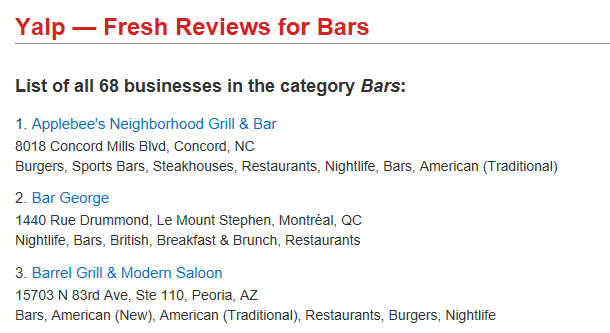

In [4]:
# access the list of all of the bars through this link:
# http://mlg.ucd.ie/modules/yalp/bars_list.html
# and print the html script of the page

barsLink = "http://mlg.ucd.ie/modules/yalp/bars_list.html"
response = urllib.request.urlopen(barsLink)
barsListHtml = response.read().decode() 

# make a data frame to keep the details about each bar
BarListDf = pd.DataFrame({"Name":[],
                          "Link":[],
                          "Location":[], 
                          "Tags":[]})

BarListDf,barNames = getInfo(barsListHtml, BarListDf)
BarListDf.head()

,Link,Location,Tags
Name,,,
Applebee's Neighborhood Grill & Bar,reviews_lU0OdZrzNmLuU7SGvONYiQ.html,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant..."
Bar George,reviews_k2a0B5nlT3V9zzVrpgcGeQ.html,QC,"[Nightlife, Bars, British, Breakfast & Brunch,..."
Barrel Grill & Modern Saloon,reviews_xxelcbat6roueQvnk3TRmA.html,AZ,"[Bars, American (New), American (Traditional),..."
Blaqcat Ultra Hookah Lounge,reviews_hFT3HuxVZJb1uYEsYfp-0A.html,NV,"[Nightlife, Coffee & Tea, Restaurants, Adult E..."
Blu Burger Grille,reviews_PMH637woNo9ojZWxPLVULw.html,AZ,"[Hot Dogs, Vegetarian, Burgers, Sandwiches, Re..."


### List of Restaurants

Now we repeat the process and get a list of all of the restaurants. We can use the same functions that we employed for the bars because the html script for the two are the same.

Below is a screenshot of the webpage that we are scraping the info from.

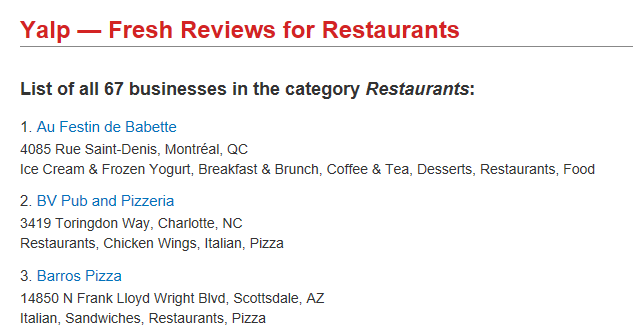

In [5]:
# access the list of all of the restaurants through this link:
# http://mlg.ucd.ie/modules/yalp/restaurants_list.html
# and print the html script of the page

restLink = "http://mlg.ucd.ie/modules/yalp/restaurants_list.html" #html link of the list of all of the restaurants
response = urllib.request.urlopen(restLink)
restListHtml = response.read().decode() 

# make a data frame to keep the details about each restaurant
restListDf = pd.DataFrame({"Name":[],
                          "Link":[],
                          "Location":[], 
                          "Tags":[]})

#use the funcion from earlier to populate the data frame of restaurants
restListDf,restNames = getInfo(restListHtml, restListDf)
restListDf.head()

,Link,Location,Tags
Name,,,
Au Festin de Babette,reviews_9YL6FpVTp9tlOm9MCqfNfA.html,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch..."
BV Pub and Pizzeria,reviews_qtotIYIF9U1PCEzMl1iE2w.html,NC,"[Restaurants, Chicken Wings, Italian, Pizza]"
Barros Pizza,reviews_vzoAKt7ND2YPLYfnVRi_Cg.html,AZ,"[Italian, Sandwiches, Restaurants, Pizza]"
Beer Garden,reviews_3QzPhQ3ltbon0-1gC7Q18Q.html,NV,"[Pubs, Pizza, Beer, Wine & Spirits, Restaurant..."
Biaggio's Pizzeria,reviews_N6MzDoao6s68nAIW8vS9dQ.html,NV,"[Italian, Restaurants, Food, Pizza, Specialty ..."


### Reviews for each Bar

In [6]:
#we're going to load all of the reviews into a Pandas DataFrame
BarReviewsDf = pd.DataFrame({"Name":[],
                      "Location":[], 
                      "Tags":[],         #some tags that describe the bar
                      "Review Text":[],  #the text from the review
                      "Rating":[],       #the rating given in the review, out of 5 stars
                        "Label":[]})     #the label associated with the review, either positive or negative

BarReviewsDf = getReviews(barNames, BarListDf, BarReviewsDf)
BarReviewsDf.head()

,Name,Location,Tags,Review Text,Rating,Label
0,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",It would help if the front girl don't just sit...,3-star,NaN
1,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",One star because that's the least amount you c...,1-star,NaN
2,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...","Bad time today. Dirty windows, table sticky, h...",2-star,NaN
3,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",My second visit in the last year. Both experie...,1-star,NaN
4,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...","Absolutely awful! Took forever to get food, fo...",1-star,NaN


Now for each bar we have to load all of the reviews. 

To do this we iterate through the list of bars we have and use the link for each bar to access that bars review page. Then we scrape all of the reviews from that webpage. 

The information we are going to take from each review is; the text from the actual review and the number of stars that were assigned to each review. 

We are also going to keep the name of the bar, the location and the tags about the bar in the hope that they can add value later.

We are going to put all of this information into a data frame with 1460 rows.

Below is a screenshot of the reviews page for the first bar.

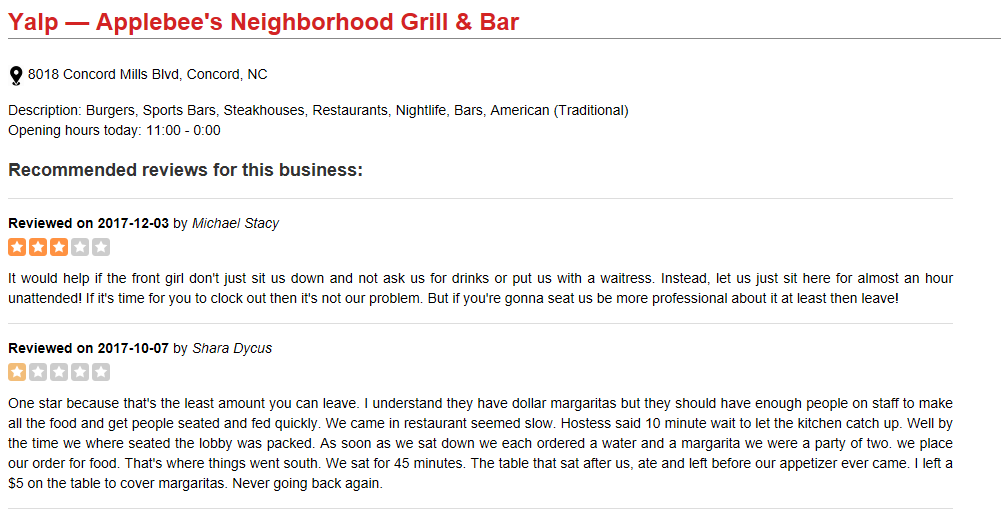

### Reviews for each Restaurant

Again for each restaurant we have to load all of the reviews. 

We are going to put all of this information into a data frame with 1440 rows. We can use the functions we developed for the bars to do this quickly.

Below is a screenshot of the reviews page for the first restaurant

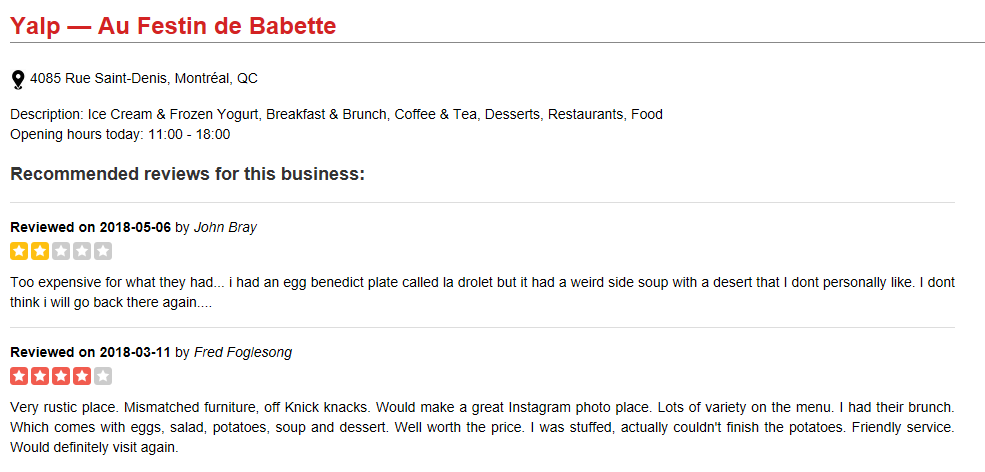

In [7]:
restReviewsDf = pd.DataFrame({"Name":[],
                      "Location":[], 
                      "Tags":[],         #some tags that describe the restaurant
                      "Review Text":[],  #the text from the review
                      "Rating":[],       #the rating given in the review, out of 5 stars
                        "Label":[]})     #the label associated with the review, either positive or negative
#use the function from earlier to populate the restaurant reviews data frame
restReviewsDf = getReviews(restNames, restListDf, restReviewsDf)
restReviewsDf.head()

,Name,Location,Tags,Review Text,Rating,Label
0,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",Too expensive for what they had... i had an eg...,2-star,NaN
1,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...","Very rustic place. Mismatched furniture, off K...",4-star,NaN
2,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",I highly recommend Au Festin de Babette for th...,5-star,NaN
3,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",Amazing soup and dauphinoise. BUT the wait for...,3-star,NaN
4,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",I went here by recommendation of a friend. Tho...,2-star,NaN


## Assign a label to each review

Next we have to go through every review and assign a classification label.

Every review has an associated rating from 1 star to 5 stars. We will assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews as “positive”.

- Negative reviews will be assigned a label of 'n'.
- Positive reviews will be assigned a label of 'p'.

In [8]:
# a function that assigns a label to each review
#for 1, 2 or 3 star the function assigns a label of n - classified as a negative review
#for 4 or 5 star the function assigns a label of p - classified as a positive review
def assignLabel(df):
    
    #create a list of labels
    labels = []
    
    #iterates over the rating column of the data frame
    for rating in df["Rating"]:
        if rating == "1-star":
            label = "n"
            labels.append(label)
        elif rating == "2-star":
            label = "n"
            labels.append(label)
        elif rating == "3-star":
            label = "n"
            labels.append(label)
        elif rating == "4-star":
            label = "p"
            labels.append(label)
        elif rating == "5-star":
            label = 'p'
            labels.append(label)
    
    #populate the empty column "Label" with the list of labels
    df["Label"] = (labels)
    
    return df

In [9]:
restReviewsDf = assignLabel(restReviewsDf)
BarReviewsDf = assignLabel(BarReviewsDf)

BarReviewsDf.head()

,Name,Location,Tags,Review Text,Rating,Label
0,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",It would help if the front girl don't just sit...,3-star,n
1,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",One star because that's the least amount you c...,1-star,n
2,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...","Bad time today. Dirty windows, table sticky, h...",2-star,n
3,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...",My second visit in the last year. Both experie...,1-star,n
4,Applebee's Neighborhood Grill & Bar,NC,"[Burgers, Sports Bars, Steakhouses, Restaurant...","Absolutely awful! Took forever to get food, fo...",1-star,n


## Cleaning Data

We realised that some ratings were in french, because they were located in Québec.

We removed these reviews as we believed they would make the classification model more inaccurate

In [10]:
#function that removes the reviews that are written in french
def removeFrenchReviews(df):
    
    #a list of numeric indexes for the rows that the reviews are written in french
    numericIndexes = []
    count = 0
    for text in df["Review Text"]:
        #function that was found at #http://blog.alejandronolla.com/2013/05/15/detecting-text-language-with-python-and-nltk/
        #detects the language of the text
        language = detect_language(text)
        if (language == "french"):
            #print(text)
            numericIndexes.append(count)
        count = count + 1
    
    #remove the rows that the reviews are in french
    df = df.drop(numericIndexes, axis = 0)
    print("{} reviews have been removed".format(len(numericIndexes)))
    
    return df
    
restReviewsDf = removeFrenchReviews(restReviewsDf)
BarReviewsDf = removeFrenchReviews(BarReviewsDf)

11 reviews have been removed
13 reviews have been removed


In [11]:
restReviewsDf.head()

,Name,Location,Tags,Review Text,Rating,Label
0,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",Too expensive for what they had... i had an eg...,2-star,n
1,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...","Very rustic place. Mismatched furniture, off K...",4-star,p
2,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",I highly recommend Au Festin de Babette for th...,5-star,p
3,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",Amazing soup and dauphinoise. BUT the wait for...,3-star,n
4,Au Festin de Babette,QC,"[Ice Cream & Frozen Yogurt, Breakfast & Brunch...",I went here by recommendation of a friend. Tho...,2-star,n


## Saving the data

We decided to save the data frames as JSON objects.

We did this so we can work with the saved files instead of pulling from the website link every time.

In [12]:
#a funtion that converts the data frame to a JSON object
def toJSON(df, name):

    fname = "{}_reviews.json".format(name)
    print("Saving parsed_results to: \"{}\"".format(fname))
    df.to_json(fname)
    print("DONE")

In [13]:
toJSON(restReviewsDf, "rest")
toJSON(BarReviewsDf, "bars")

Saving parsed_results to: "rest_reviews.json"
DONE
Saving parsed_results to: "bars_reviews.json"
DONE


# Import Data

In [14]:
#loads the saved JSON objects back into data frames

fname = "rest_reviews.json"
print("Loading search_data from: \"{}\"".format(fname))
restaurants = pd.read_json(fname)
print("Loaded {:,} reviews".format(len(restaurants)))

fname = "bars_reviews.json"
print("Loading search_data from: \"{}\"".format(fname))
bars = pd.read_json(fname)
print("Loaded {:,} reviews".format(len(bars)))

Loading search_data from: "rest_reviews.json"
Loaded 1,429 reviews
Loading search_data from: "bars_reviews.json"
Loaded 1,447 reviews


## Seperating features and labels

When working with machine learning models it is industry standard to use two different structures for the labels and features.

In [15]:
R_labels = list(restaurants['Label'])
R_features = restaurants.drop(['Label','Rating'], axis=1)
# print(R_labels[:10])
# R_features.head()

B_labels = list(bars['Label'])
B_features = bars.drop(['Label','Rating'], axis=1)
# print(B_labels[:10])
# B_features.head()

# Preprocessing and Classification

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk import wordpunct_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import re

from collections import Counter

[nltk_data] Downloading package stopwords to /home/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/james/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


There are 3 seperate steps to be undertaken:

- (a) Apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.
- (b) Build a classification model using a model of your choice, to distinguish between “positive” and “negative” reviews.
- (c) Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

## Creating a numeric representation of the text data


There are a number of text preprocessing steps that can be taken to simplify the text data.
For our text we use the following preprocessing techniques:
- stop word filtering
- lemmatisation
- minimum term length filtering
- case conversion
- low frequency filtering

This will reduce the number of unique terms, and in turn make our document-term matrix smaller.

We construct a document-term matrix using a TFidfVectorizer, because we believed it would improve the usefulness of the document-term matrix by giving higher weights to more "important" terms.

In [17]:
def custom_tokenizer(text, 
              tokenizer=nltk.data.load('tokenizers/punkt/english.pickle'), 
              MIN_LEN=2,
              lemmatizer = nltk.WordNetLemmatizer()):
    
    sentences = tokenizer.tokenize(text) #split the text into sentences
    
    #split the sentences into words
    sentences = [re.compile('\w+').findall(sentence) for sentence in sentences]
    
    #join the sentences into a single list of words
    words = [word for sentence in sentences for word in sentence]
    
    words = [word for word in words if len(word)>MIN_LEN]
    words = [lemmatizer.lemmatize(word, 'v') for word in words]
    #The second argument to lemmatize() is the broad word class: ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    return words

bars_test = [custom_tokenizer(bar) for bar in B_features['Review Text'][:2]]
print(*bars_test,sep="\n")

['would', 'help', 'the', 'front', 'girl', 'don', 'just', 'sit', 'down', 'and', 'not', 'ask', 'for', 'drink', 'put', 'with', 'waitress', 'Instead', 'let', 'just', 'sit', 'here', 'for', 'almost', 'hour', 'unattended', 'time', 'for', 'you', 'clock', 'out', 'then', 'not', 'our', 'problem', 'But', 'you', 'gonna', 'seat', 'more', 'professional', 'about', 'least', 'then', 'leave']
['One', 'star', 'because', 'that', 'the', 'least', 'amount', 'you', 'can', 'leave', 'understand', 'they', 'have', 'dollar', 'margaritas', 'but', 'they', 'should', 'have', 'enough', 'people', 'staff', 'make', 'all', 'the', 'food', 'and', 'get', 'people', 'seat', 'and', 'feed', 'quickly', 'come', 'restaurant', 'seem', 'slow', 'Hostess', 'say', 'minute', 'wait', 'let', 'the', 'kitchen', 'catch', 'Well', 'the', 'time', 'where', 'seat', 'the', 'lobby', 'be', 'pack', 'soon', 'sit', 'down', 'each', 'order', 'water', 'and', 'margarita', 'be', 'party', 'two', 'place', 'our', 'order', 'for', 'food', 'That', 'where', 'things',

We set all of the parameters for our TfidfVectorizer.

We chose a TfidfVectorizer over a simple count vectoriser because it improves the usefulness of the document-term matrix by
giving higher weights to more "important" terms. Terms that appear in almost every document are penalised and weighted as less important than terms that appear in few documents.

- strip_accents='unicode', Remove accents and perform other character normalization during the preprocessing step
- lowercase=True, Convert all characters to lowercase before tokenizing
- preprocessor=None, Override the preprocessing stage while preserving the tokenizing and n-grams generation steps
- tokenizer=custom_tokenizer, Override the string tokenization step while preserving the preprocessing and n-grams generation steps.
- stop_words=set(nltk.corpus.stopwords.words('english')), specify our own stopword set
- ngram_range=(1, 3), The lower and upper boundary of the range of n-values for different n-grams to be extracted
- max_df=1.0, When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
- min_df=1, When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
- analyzer='word'

In [18]:
vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, preprocessor=None, 
                             tokenizer=custom_tokenizer, stop_words=set(nltk.corpus.stopwords.words('english')),
                             ngram_range=(1, 3), 
                             analyzer='word', max_df=1.0, min_df=1)

We construct two document term matrices: R_vector and B_vector and print out their shape.

R_vector has 1,429 different documents and 137,103 unique terms.
B_vector has 1,447 different documents and 143,569 unique terms

In [19]:
R_vector = vectorizer.fit_transform(R_features['Review Text'])
print(R_vector.shape)

/usr/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(1429, 137103)


In [20]:
B_vector = vectorizer.fit_transform(B_features['Review Text'])
print(B_vector.shape)

(1447, 143569)


# Determining which Classifier to use

In [21]:
#we import the various models from sci-kitlearn
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB #Naive Bayes

#we load the models into a dictionary, so we can iterate through and call each one
models = {'LinearSVC':LinearSVC(), 'LogisticRegression':LogisticRegression(solver='lbfgs', multi_class='auto'), 'Naive Bayes': MultinomialNB(), 'KNeighbours': KNeighborsClassifier(n_neighbors=3)}

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

A number of different classifiers were examined;
- Linear Support Vector Machine
- K nearest neighbours classifier
- Logistic Regression
- Naive Bayes

Each classifier has a different implementation "under the hood". 

Since our data set is small, we have the ability to run each classifier and compare their accuracies. In an industrial setting this may not always be possible due to large data sets. Therefore we investigated the inner workings of each classifier to determine which we expected would be most accurate.

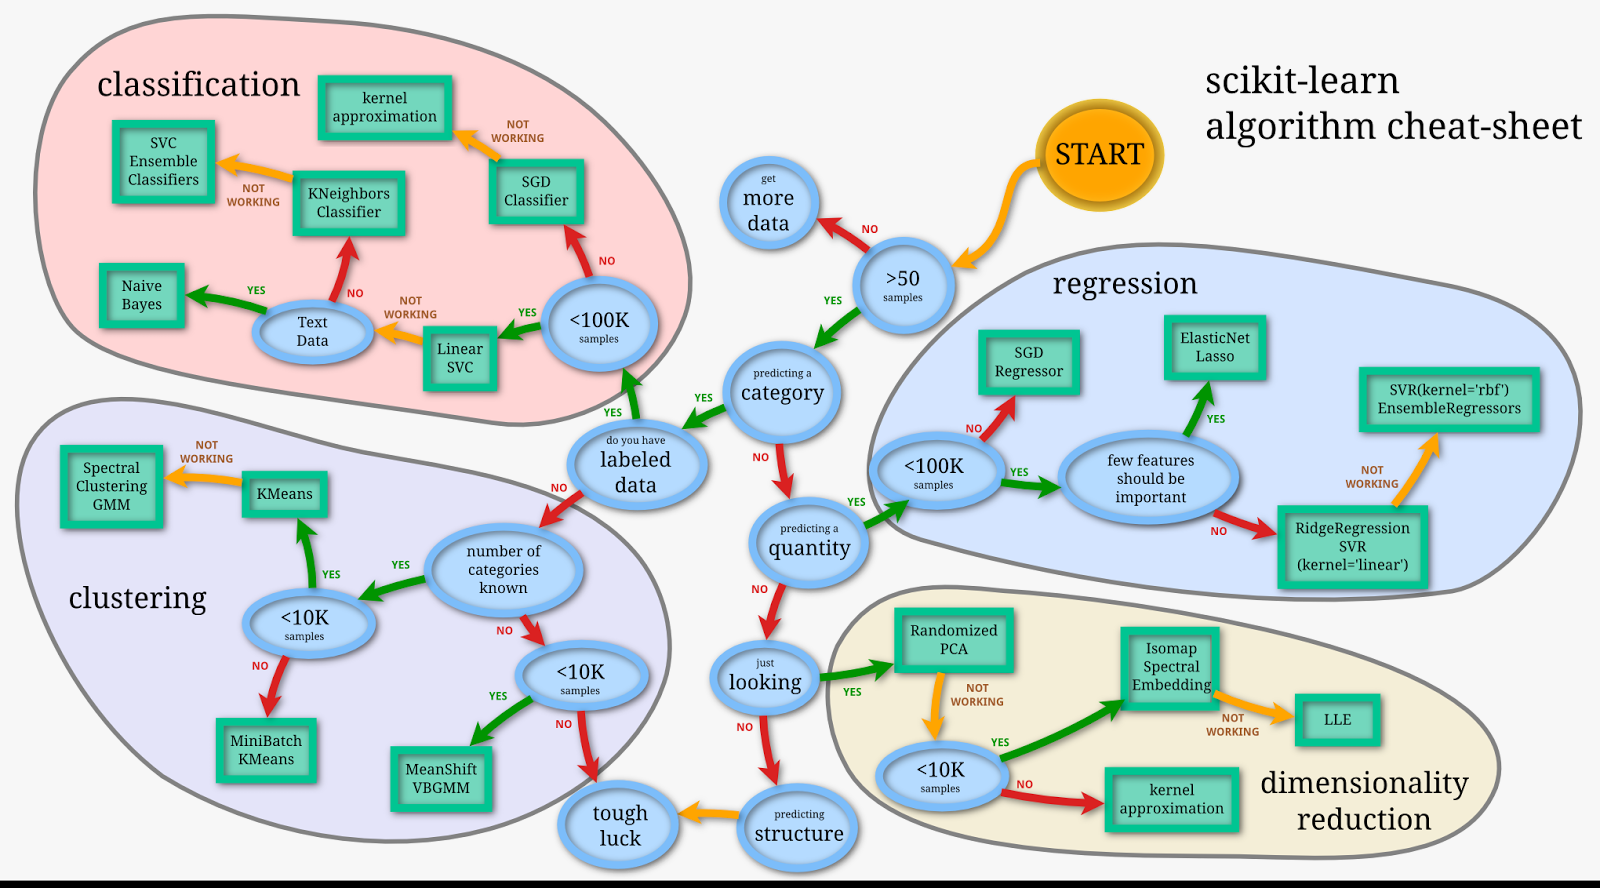

The Support Vector Machine model constructs hyperplanes in a multidimensional space that separates cases of different class labels to minimise the loss function (error) between the training features and labels. This will work well with the term frequency-inverse document frequency vectorizer which will indicate the relevance of terms. 

The Naive Bayes model assumes that the label associated with a feature is unrelated (independent) to the presence or absence of any other features, which isn't true for natural language as context is very important. Using a ngram vectoriser will improve the accuracy by providing more context and making the features more independent.

The K-Neighbours model relies on clustering of data being indicative of labels. However with high dimensional data and a bag of words representation there is very low correlation between the geometry of the data and the labels. Using a word2vec approach would result in this model performing better. 

The Logistic Regression model is not originally meant as a classifier function and hence is already on the backfoot. It assigns features positive or negative weights if they have positive or negative rating levels respectively and sums these weights before making a decision based on whether the review is overall negative or positive. This again does not properly deal with context. 

After our investigations into the workings of the classifiers, we predict that a Support Vector Machine should be the most accurate, while Naive Bayes should perform the worst. 

The primary text that we consulted in our research was "The Hundred Page Machine Learning Book" by Andriy Burkov. 

## Test functions

In [22]:
def display_results(results):
    '''    A function to display the accuracy results from the various models.
    The accuracies are displayed in tabular and graphical form.    '''
    #sort ascending, by values
    results_sorted = sorted(results.items(), key=lambda kv: kv[1]) 
    
    #Model Accuracy Graph
    results_names, results_vals = zip(*results_sorted)
    plt.figure(figsize = (8,6))
    plt.bar(results_names, results_vals)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) #set y axis to percent
    
    plt.title("Model comparison", fontsize=20)      
    plt.xlabel("Model", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.show()
    
    #Model Accuracy Table
    print(f"\t\t{'Classifier':20}| \tAccuracy")
    print("\t", "-"*50)
    for name, val in results_sorted[::-1]:
        print(f'\t\t{name:20}| \t {val:.02%}')
          

def compare_models(models, features, labels, KFOLDS = 5):
    '''    A function that iterates through the dictionary of models and runs each model on the test data.
    It then compares the accuracy results for the various models  '''
          
    results = dict()

    #test each model
    for model_name, model in models.items():
        scores = cross_val_score(model, features, labels, cv=KFOLDS)
        results[model_name] = scores.mean()
    
    display_results(results)
          
    return results

## Bars

We run the classifiers on the bar reviews and compare their performance.

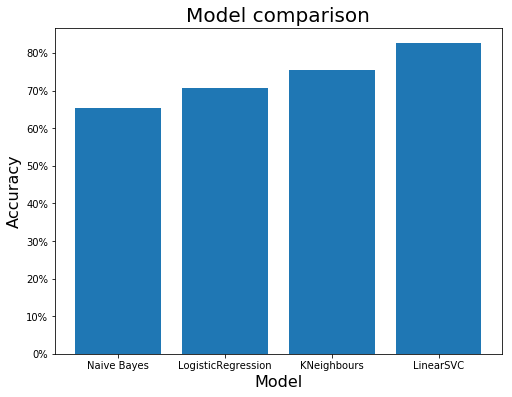

		Classifier          | 	Accuracy
	 --------------------------------------------------
		LinearSVC           | 	 82.58%
		KNeighbours         | 	 75.46%
		LogisticRegression  | 	 70.56%
		Naive Bayes         | 	 65.31%


In [23]:
results_bar = compare_models(models, B_vector, B_labels)

## Restaurants

We run the classifiers on the restaurant reviews and compare their performance.

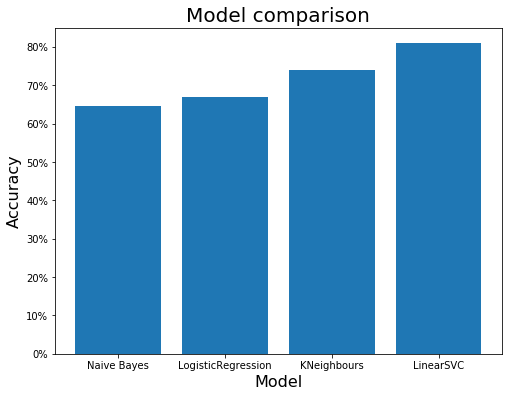

		Classifier          | 	Accuracy
	 --------------------------------------------------
		LinearSVC           | 	 80.97%
		KNeighbours         | 	 73.90%
		LogisticRegression  | 	 67.04%
		Naive Bayes         | 	 64.66%


In [24]:
results_rest = compare_models(models, R_vector, R_labels)

## Average Accuracy

We calculate the mean accuracy of the models on each data set.

AVERAGE OVERALL:


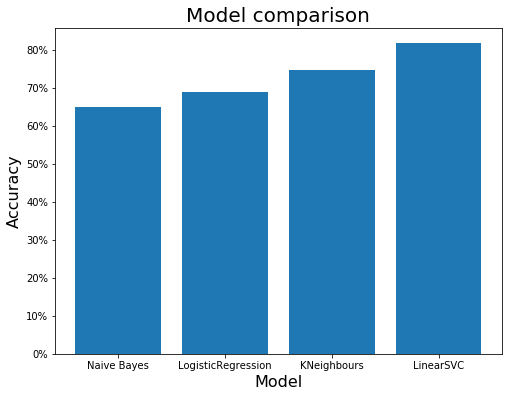

		Classifier          | 	Accuracy
	 --------------------------------------------------
		LinearSVC           | 	 81.78%
		KNeighbours         | 	 74.68%
		LogisticRegression  | 	 68.80%
		Naive Bayes         | 	 64.98%


In [25]:
print('AVERAGE OVERALL:')
results_overall=dict()
for model in models:
    results_overall[model] = (results_bar[model]+results_rest[model])/2
display_results(results_overall)

LinearSVC performed the best as we predicted with 82%.

Naive Bayes performed the worst with an accuracy of only 65%, this is only 15% more accurate than random guessing which should be correct around 50% of the time.

# Further investigation of the LinearSVC Classifier

Because LinearSVC was the most accurate classifier, we evaluated its performance in more detail.

- We print the first ten predictions and compare them to the actual labels to get an idea of how the model is performing.
- We look at the overall accuracy of the model in classifying the test data.
- We print a classification report to examine the precision and recall of the model.
- We print a confusion matrix to investigate the mistakes the classifier made - in identifying false negatives and false positives.

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#function for evaluating the LinearSVC model all at once
def eval_model(model, test_set, test_labels):
    preds = model.predict(test_set)
    
    #print() the first ten predictions and actual results against each other
    print("Sample: ")
    print(f"Prediction: {list(preds[:10])}",)
    print(f"Actual Val: { test_labels[:10]}\n")

    #print the accuracy of the model in classifying the test data
    print(f"Accuracy: {accuracy_score(test_labels, preds):.2%}\n")

    #print a classification report
    print("Classification Report:\n", "-"*60)
    print(classification_report(test_labels, preds))

    #print a confusion matrix
    print("Confusion Matrix\n", "-"*60)
    print(confusion_matrix(test_labels, preds))

## Bars

We split the data, train the model and then evaluate it bit by bit.

In [27]:
features = B_vector
labels = B_labels

#split the data into training and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = LinearSVC()

#train the model
model.fit(features_train, labels_train)
#run the model on the test data to find its predictions
preds = model.predict(features_test)

### Accuracy

In [28]:
#print() the first ten predictions and actual results against each other
print("Sample: ")
print(f"Prediction: {list(preds[:10])}",)
print(f"Actual Val: { labels_test[:10]}\n")

#print the accuracy of the model in classifying the test data
print(f"Accuracy: {accuracy_score(labels_test, preds):.2%}")

Sample: 
Prediction: ['n', 'p', 'p', 'p', 'p', 'p', 'p', 'n', 'p', 'n']
Actual Val: ['n', 'p', 'n', 'p', 'p', 'p', 'p', 'n', 'n', 'n']

Accuracy: 84.14%


The LinearSVC gives an accuracy of 84.14% which is a reasonably good performance.
We see in the first ten predictions that are displayed to us that two mistakes are made, the third and the ninth prediction. Two mistakes in 10 reviews makes sense given the accuracy value of 84.14%.

Both of the initial mistakes are false positives which makes sense seeing as there are 41 false positive mistakes and only 5 false negatives from the entire 290 reviews. (seen later in the confusion matrix)

### Classification Report

In [29]:
#print a classification report
print("Classification Report:\n", "-"*60)
print(classification_report(labels_test, preds))

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.93      0.63      0.75       111
           p       0.81      0.97      0.88       179

   micro avg       0.84      0.84      0.84       290
   macro avg       0.87      0.80      0.82       290
weighted avg       0.86      0.84      0.83       290



The classification report shows that the model has a precision of 0.93 in identifying negatives. Which means that 93% of the negatives it predicted were actually negatives.

The model had a precision of 0.81 in identifying positives, 81% of the positives it identified were actually positive.

The recall of the model for positives was excellent. It identified 97% of the overall number of positive reviews as positive.

The recall of the model for negatives was less good, of all of the negative reviews, it only identified 63% of them correctly.

### Confusion Matrix

In [30]:
#print a confusion matrix
print("Confusion Matrix\n", "-"*15)
print(confusion_matrix(labels_test, preds))

Confusion Matrix
 ---------------
[[ 70  41]
 [  5 174]]


The confusion matrix is slightly unusual that the True negatives are in the top left corner, and the True positives in the bottom right

The results from the classification reports are reflected in the confusion matrix. There are a large number of false positives, which explains the low negative recall. 

It can also be seen that there are far more positive reviews than negative reviews. This explains the bias in the model. Because of the greater number of positive reviews, it was more likely to predict that a review was positive. This is the reason for te high number of false positives.

Therefore we will build and evaluate the model again, this time however with a balanced data set.

## Restaurants

Repeating the above for the restaurant dataset

In [31]:
features = R_vector
labels = R_labels

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = LinearSVC()
model.fit(features_train, labels_train)

#we evaluate the model all at the same time 
eval_model(model, features_test,labels_test)

Sample: 
Prediction: ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'n', 'p']
Actual Val: ['p', 'p', 'n', 'p', 'p', 'p', 'p', 'p', 'n', 'p']

Accuracy: 83.22%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.97      0.58      0.72       109
           p       0.79      0.99      0.88       177

   micro avg       0.83      0.83      0.83       286
   macro avg       0.88      0.78      0.80       286
weighted avg       0.86      0.83      0.82       286

Confusion Matrix
 ------------------------------------------------------------
[[ 63  46]
 [  2 175]]


The LinearSVC gives an accuracy of 83% for the restaurants which is a similar performance to the bars.

The classification report shows the precision and recall for the model trained and tested on the restaurants. 

The thing that is of most interest in this case is not the numbers themselves, but the pattern they take. They follow the same pattern as the numbers for the bars. A high precision in identifying negative reviews, and a high recall for positive reviews. As well as this there is a low recall in identifying negative reviews.

(The confusion matrix is slightly unusual that the True negatives are in the top left corner, and the True positives in the bottom right)

These results are reflected again in the confusion matrix. Providing more evidence that indicates that the model is biased due to the presence of more positive reviews than negative reviews

# Balancing the data sets

First we count the number of positive and negative reviews in each case

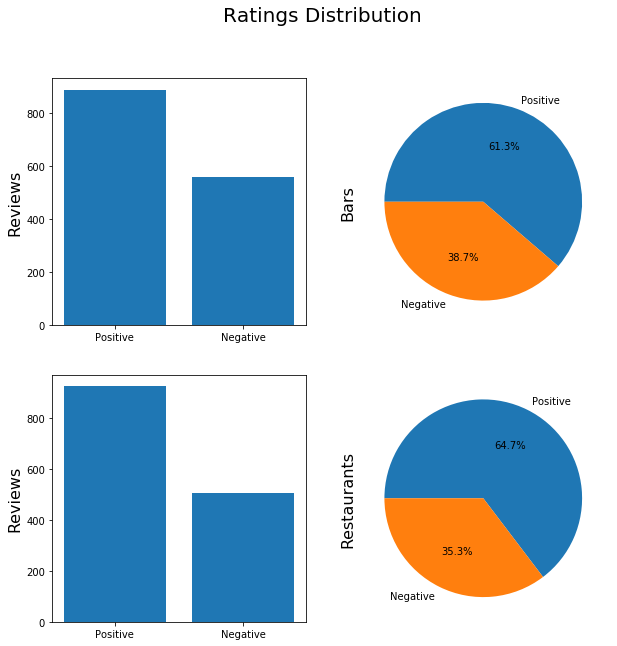

In [32]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("Ratings Distribution", fontsize = 20)

bars_counter = [Counter(B_labels)['p'], Counter(B_labels)['n']]
rest_counter = [Counter(R_labels)['p'], Counter(R_labels)['n']]
labels = ['Positive', 'Negative']

          
bars_b = fig.add_subplot(2,2,1)
bars_b.bar(labels, bars_counter)
bars_b.set_ylabel("Reviews", fontsize = 16)
    
bars_p = fig.add_subplot(2,2,2)
bars_p.pie(bars_counter, labels = labels, autopct='%1.1f%%', startangle=180, counterclock=False)
bars_p.set_ylabel("Bars", fontsize = 16)

rest_b = fig.add_subplot(2,2,3)
rest_b.bar(labels, rest_counter)
rest_b.set_ylabel("Reviews", fontsize = 16)

rest_p = fig.add_subplot(2,2,4)
rest_p.pie(rest_counter, labels = labels, autopct='%1.1f%%', startangle=180, counterclock=False)
rest_p.set_ylabel("Restaurants", fontsize = 16)

plt.show()

There are far more positive reviews than there are negative reviews. We will remove some positive reviews so that there are the same number of positive and negative reviews.

In [33]:
#found online at https://www.developintelligence.com/blog/2017/03/predicting-yelp-star-ratings-review-text-python/

#a function for balancing the number of reviews from each category
def balance_classes(xs, ys):
    
    """Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
 
    # the least common class is the maximum number we want for all classes
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    
    new_ys = []
    new_xs = []
    
    for i, y in enumerate(ys):
        
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
            
    return new_xs, new_ys

In [34]:
#balance the bar reviews
B_features_balanced, B_labels_balanced = balance_classes(list(B_features["Review Text"]), B_labels)
print(f'{len(B_labels)-len(B_labels_balanced)} positive reviews removed to balance the bar dataset')

#balance the restaurant reviews
R_features_balanced, R_labels_balanced = balance_classes(list(R_features["Review Text"]), R_labels)
print(f'{len(R_labels)-len(R_labels_balanced)} positive reviews removed to balance the restaurant dataset')

#vectorise the features
R_vector_balanced = vectorizer.fit_transform(R_features_balanced)
B_vector_balanced = vectorizer.fit_transform(B_features_balanced)

327 positive reviews removed to balance the bar dataset
419 positive reviews removed to balance the restaurant dataset


## Performance on the balanced data set

The Linear SVC model performed the best again (only marginally this time). We investigate the performance of this model in more detail.

In [52]:
features = B_vector_balanced
labels = B_labels_balanced

#split the data into training and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
model = LinearSVC()
model.fit(features_train, labels_train) #train the model
eval_model(model, features_test,labels_test) #evaluate the model

Sample: 
Prediction: ['p', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n']
Actual Val: ['p', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n']

Accuracy: 90.62%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.89      0.91      0.90       103
           p       0.92      0.90      0.91       121

   micro avg       0.91      0.91      0.91       224
   macro avg       0.91      0.91      0.91       224
weighted avg       0.91      0.91      0.91       224

Confusion Matrix
 ------------------------------------------------------------
[[ 94   9]
 [ 12 109]]


The improvement in performance is evident in all of the measures. 

We see that the accuracy of the Linear SVC here is higher than the accuracy of the Linear SVC when comparing the classifiers (both cases we are referring to the balanced data set LinearSVC). This is likely due to the k-fold cross validation that is performed during the comparing of the classifiers.

The precision and the recall are all high. The major improvement can be seen in the recall of negative reviews - there was an improvement from 0.63 to 0.91. The f1-score of the positive and negative reviews increase.

The confusion matrix also sees an improvement. There are still some false positives and false negatives, however, there is no longer a bias in the model to predict more reviews as positive. 

In [36]:
features = R_vector_balanced
labels = R_labels_balanced

#split the data into training and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)
model = LinearSVC()
model.fit(features_train, labels_train) #train the model
eval_model(model, features_test,labels_test) #evaluate the model

Sample: 
Prediction: ['p', 'n', 'p', 'p', 'n', 'p', 'p', 'p', 'p', 'n']
Actual Val: ['p', 'n', 'p', 'p', 'n', 'p', 'p', 'p', 'p', 'n']

Accuracy: 90.10%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.88      0.93      0.91       107
           p       0.92      0.86      0.89        95

   micro avg       0.90      0.90      0.90       202
   macro avg       0.90      0.90      0.90       202
weighted avg       0.90      0.90      0.90       202

Confusion Matrix
 ------------------------------------------------------------
[[100   7]
 [ 13  82]]


The performance of the model on the restaurants is very similar.

The significant change is again the increase of the recall of negative reviews. In this case it increased from 0.55 to 0.93. The f1-score increased in both cases, this demonstrates the overall increase of both recall and precision. 

The confusion matrix displays similar improvements as the confusion matrix for the bars. There appears to be more mistakes being made in identifying false negatives (bottom left corner) in both cases. However the difference is too small to be considered significant, more analysis would have to be done to confirm this bias.

Overall the balancing of the data improves performance in all measured parameters. Therefore we conclude that balancing the data was a success. 

NOTE: In reviewing this assignment in preparation to submit it is noted that the test dataset should not have been balanced also. This should not effect our results however a more intelligent classifier with memory of previous classifications may have been able to begin making predictions on what the next prediction should be based on the distribution of predictions so far.

# Model Transferability

There are two bits to be completed for this section.

- 8.1: Train a classification model on the data from “Restaurants”, and evaluate its performance on the data from “Bars”.
- 8.2: Train a classification model on the data from “Bars”, and evaluate its performance on the data from “Restaurants”.

## Train on the data from “Restaurants”, and test on the data from “Bars”.

In [37]:
#set up the vectors for transferability
R_vector = vectorizer.fit_transform(R_features['Review Text'])
B_vector = vectorizer.transform(B_features['Review Text'])

model = LinearSVC()
model.fit(R_vector, R_labels) #train the model on the restaurant data
eval_model(model, B_vector, B_labels) #test on the bar data

Sample: 
Prediction: ['n', 'n', 'p', 'p', 'n', 'n', 'n', 'p', 'p', 'n']
Actual Val: ['n', 'n', 'p', 'p', 'p', 'n', 'p', 'p', 'n', 'n']

Accuracy: 86.66%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.87      0.77      0.82       560
           p       0.86      0.93      0.90       887

   micro avg       0.87      0.87      0.87      1447
   macro avg       0.87      0.85      0.86      1447
weighted avg       0.87      0.87      0.86      1447

Confusion Matrix
 ------------------------------------------------------------
[[429 131]
 [ 62 825]]


This exercise yields an interesting result.

The model that was trained on the restaurant reviews is more accurate at predicting the sentiment of bar reviews!

This model achieves an accuracy of 86.66% where are the model trained and tested on bars achieves 84.14%. The difference is small, but it is still a surprising result!

## Train on the data from “Bars”, and test on the data from “Restaurants”

In [38]:
#set up the models for transferability
B_vector = vectorizer.fit_transform(B_features['Review Text'])
R_vector = vectorizer.transform(R_features['Review Text'])

model.fit(B_vector, B_labels) #train the model with the bar data
eval_model(model, R_vector, R_labels) #test on the restaurant data

Sample: 
Prediction: ['n', 'p', 'n', 'n', 'n', 'n', 'n', 'p', 'n', 'n']
Actual Val: ['n', 'p', 'p', 'n', 'n', 'n', 'n', 'p', 'n', 'n']

Accuracy: 86.07%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.80      0.82      0.81       505
           p       0.90      0.89      0.89       924

   micro avg       0.86      0.86      0.86      1429
   macro avg       0.85      0.85      0.85      1429
weighted avg       0.86      0.86      0.86      1429

Confusion Matrix
 ------------------------------------------------------------
[[412  93]
 [106 818]]


Again a similar result is obtained! The model is more accurate at predicting the sentiment in another category than its own category!

The accuracy increased by 3% when trained on the bar reviews rather than the restaurant reviews. The f1 score increased for both negative and positive reviews.

We hypothesised at the start of our project that the models would be accurate at predicting the sentiment of reviews from each category because bars and restaurants are so similar. However, we didn't expect them to be more accurate on one another. The authors cannot explain why this is and propose that it is most likely pure coincidence.

## Testing using entire balanced dataset 

In [ ]:
ALL_features = pd.concat([B_features, R_features], ignore_index=True)
ALL_labels = B_labels+R_labels #concatenate lists

ALL_features_balanced, ALL_labels_balanced = balance_classes(list(ALL_features['Review Text']), ALL_labels)
print(f'{len(ALL_labels)-len(ALL_labels_balanced)} positive reviews removed to balance the dataset')

ALL_vector_balanced = vectorizer.fit_transform(ALL_features_balanced)

In [40]:
features_train, features_test, labels_train, labels_test = train_test_split(ALL_vector_balanced, ALL_labels_balanced, test_size=0.2, random_state=42)

model = LinearSVC()
model.fit(features_train, labels_train)
eval_model(model, features_test,labels_test)b

Sample: 
Prediction: ['p', 'n', 'n', 'p', 'n', 'p', 'n', 'n', 'n', 'n']
Actual Val: ['p', 'n', 'n', 'p', 'n', 'p', 'n', 'n', 'n', 'n']

Accuracy: 90.61%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           n       0.91      0.90      0.91       213
           p       0.90      0.91      0.91       213

   micro avg       0.91      0.91      0.91       426
   macro avg       0.91      0.91      0.91       426
weighted avg       0.91      0.91      0.91       426

Confusion Matrix
 ------------------------------------------------------------
[[192  21]
 [ 19 194]]


Here we can see an increase in the accuracy of the model when we feed it the combined datasets. This indicates that the bar and restaurant categories share the same features that indicate whether it is positive or negative.
Hence with the increased amount of training data the model is able to more accurately predict the sentiment of a given review.
Also of note is that fact the number of false positives and false negatives is now equal as well as we have a balanced data set now.

# Training the model to give specific ratings

## Creating the star labels

In [41]:
B_labels_r = [rating[0] for rating in list(bars['Rating'])] #strip just the number
R_labels_r = [rating[0] for rating in list(restaurants['Rating'])] #strip just the number

In [42]:
count_b = Counter(B_labels_r)
count_r = Counter(R_labels_r)

#count labels for bars
bars_counter = [count_b[str(i+1)] for i in range(5)]
rest_counter = [count_r[str(i+1)] for i in range(5)]

## Balancing the rating label data

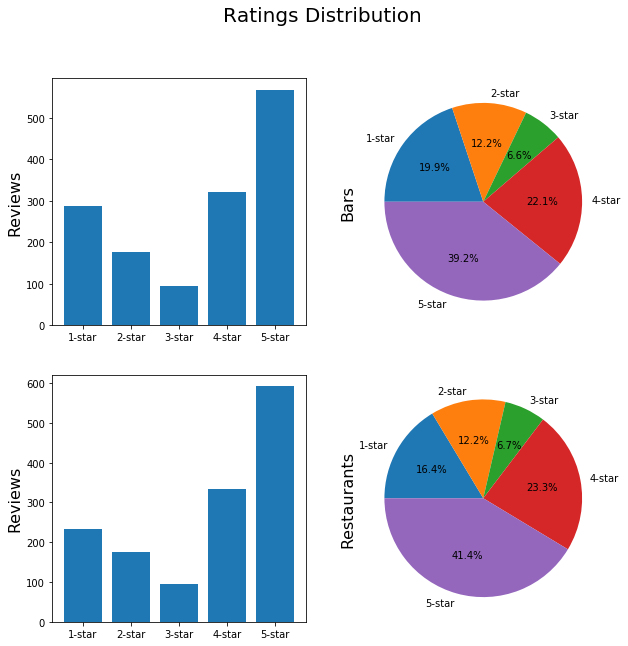

In [43]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("Ratings Distribution", fontsize = 20)

labels = [f"{i+1}-star" for i in range(5)]
          
bars_b = fig.add_subplot(2,2,1)
bars_b.bar(labels, bars_counter)
bars_b.set_ylabel("Reviews", fontsize = 16)
    
bars_p = fig.add_subplot(2,2,2)
bars_p.pie(bars_counter, labels = labels, autopct='%1.1f%%', startangle=180, counterclock=False)
bars_p.set_ylabel("Bars", fontsize = 16)

rest_b = fig.add_subplot(2,2,3)
rest_b.bar(labels, rest_counter)
rest_b.set_ylabel("Reviews", fontsize = 16)

rest_p = fig.add_subplot(2,2,4)
rest_p.pie(rest_counter, labels = labels, autopct='%1.1f%%', startangle=180, counterclock=False)
rest_p.set_ylabel("Restaurants", fontsize = 16)

plt.show()

Looking at the distribution of the dataset it is obvious the dataset is skewed to either end. There is also not many values in the smallest set (there are 95 and 96 3-star reviews for bars and restaurants respectively). This would mean that after balancing our data we would have a very small data set (<1000 reviews) with which to train our model. 
Hence to give the model a fighting chance we will use both datasets at once.

## Ratings, whole dataset

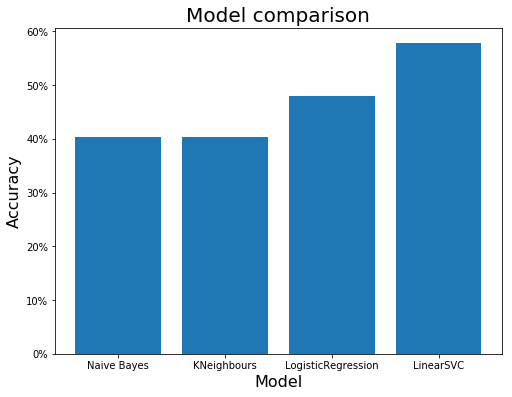

		Classifier          | 	Accuracy
	 --------------------------------------------------
		LinearSVC           | 	 57.82%
		LogisticRegression  | 	 47.91%
		KNeighbours         | 	 40.44%
		Naive Bayes         | 	 40.30%


In [44]:
ALL_labels_r = B_labels_r + R_labels_r
ALL_vector = vectorizer.fit_transform(ALL_features['Review Text'])

results_bar = compare_models(models, ALL_vector, ALL_labels_r)

Here we can see the model performs dreadfully with its accuracy below 50% for all but the LinearSVC model. Random chance is 20% for 5 values

In [45]:
features = ALL_vector
labels = ALL_labels_r

#split the data into training and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = LinearSVC()
model.fit(features_train, labels_train) #train the model
eval_model(model, features_test,labels_test) #evaluate the model

Sample: 
Prediction: ['5', '5', '5', '1', '4', '5', '4', '4', '5', '1']
Actual Val: ['4', '5', '4', '2', '3', '4', '4', '4', '5', '1']

Accuracy: 57.29%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.60      0.81      0.69        96
           2       0.57      0.06      0.10        71
           3       0.00      0.00      0.00        42
           4       0.39      0.23      0.29       122
           5       0.60      0.90      0.72       245

   micro avg       0.57      0.57      0.57       576
   macro avg       0.43      0.40      0.36       576
weighted avg       0.51      0.57      0.49       576

Confusion Matrix
 ------------------------------------------------------------
[[ 78   1   0   5  12]
 [ 32   4   0  12  23]
 [  7   1   0   9  25]
 [  6   0   0  28  88]
 [  6   1   0  18 220]]


/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Here we can see our prediction was correct. The model is massively biased to the high star reviews with 148 false positives for the 5-star rating and the model getting zero of the 3-star ratings correct.

## Ratings, whole dataset balanced

In [49]:
ALL_features_balanced, ALL_labels_r_balanced = balance_classes(list(ALL_features['Review Text']), ALL_labels_r)
print(f'{len(ALL_labels_r)-len(ALL_labels_r_balanced)} positive reviews removed to balance the dataset')

ALL_vector_r_balanced = vectorizer.fit_transform(ALL_features_balanced)

1921 positive reviews removed to balance the dataset


In [50]:
features = ALL_vector_r_balanced
labels = ALL_labels_r_balanced

#split the data into training and test
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = LinearSVC()
model.fit(features_train, labels_train) #train the model
eval_model(model, features_test,labels_test) #evaluate the model

Sample: 
Prediction: ['5', '5', '1', '1', '5', '1', '4', '3', '1', '1']
Actual Val: ['5', '5', '3', '3', '4', '1', '3', '2', '1', '1']

Accuracy: 47.64%

Classification Report:
 ------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.59      0.76      0.67        38
           2       0.45      0.23      0.31        39
           3       0.45      0.31      0.37        42
           4       0.31      0.31      0.31        36
           5       0.50      0.81      0.62        36

   micro avg       0.48      0.48      0.48       191
   macro avg       0.46      0.48      0.45       191
weighted avg       0.46      0.48      0.45       191

Confusion Matrix
 ------------------------------------------------------------
[[29  5  3  0  1]
 [ 8  9  9  8  5]
 [ 9  4 13 10  6]
 [ 2  2  4 11 17]
 [ 1  0  0  6 29]]


Now we have a balanced classifier however the accuracy has suffered a lot (10% less accurate) because of the reduction of significant reduction in the size of the dataset.

# Conclusion

In this assignment review data was scraped from a webpage and processed. Then a classifier was developed to classify the sentiment of reviews into positive and negative categories. Initially an accuracy of over 84% was achieved. This was improved to over 90% by balancing the dataset. 

The model transferability proved to be very strong as the models testing the model trained on one dataset on the other proved to be effective. Thus dataset size was increased by joining the bar and restaurant datasets. 

Finally it was shown that the dataset was too small and unbalanced to prove effective for training a classifier which could accurately determine the exact rating a review would receive. 